In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('../..'))))

import torch
import numpy as np
from src.models.feature.GooLeNet import GoogLeNet
from src.models.feature.ResNet import ResNet18

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'
    torch.set_default_tensor_type('torch.FloatTensor')
    
class_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#class_name = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

In [3]:
model = ResNet18(alpha=1, cal='mul').to(device)

model.load_state_dict(torch.load('./log/resnet18_cifar10_gvap_model_mul_10.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Block1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (relu2): ReLU()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1):

In [5]:
feature_blobs = []

def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())

print(model._modules)

model._modules.get('Block4').register_forward_hook(hook_feature)

params = list(model.parameters())

class_weights = np.squeeze(params[-2].cpu().data.numpy())

OrderedDict([('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))), ('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)), ('relu1', ReLU()), ('max_pool1', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('Block1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
    (relu2): ReLU()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = './test_img/cifar10/test.png'

img = Image.open(img_path)

plt.imshow(img)

In [7]:
import torchvision.transforms as transforms
from torch.autograd import Variable

cvt_tensor = transforms.Compose([transforms.Resize((128,128)),
                                 transforms.ToTensor()])

tensor_img = cvt_tensor(img).to(device)

tensor_img = tensor_img.view(1, 3, 128,128)

tensor_img = Variable(tensor_img, requires_grad=True)

output = model(tensor_img)

In [8]:
from torch.nn import functional as F

h_x = F.softmax(output, dim=1).data.squeeze()

In [9]:
print(h_x.sort(0, True))

pred = h_x.argmax(0).item()
print(pred)
print(class_name[pred])

torch.return_types.sort(
values=tensor([4.0827e-01, 3.0532e-01, 2.8603e-01, 3.1410e-04, 6.6195e-05, 1.2343e-06,
        1.0469e-06, 1.8502e-15, 2.1181e-17, 3.3172e-19]),
indices=tensor([9, 1, 7, 6, 0, 2, 4, 8, 3, 5]))
9
truck


In [10]:
feature_blobs[0][0].shape

(512, 4, 4)

In [11]:
class_weights.shape

(10, 512)

In [12]:
final_conv = feature_blobs[0][0]

cam = np.zeros(dtype=np.float32, shape=final_conv.shape[1:3])

for i, w in enumerate(class_weights[pred]):
    cam += w*final_conv[i,:,:]

In [13]:
def gen_feature_map(feature_):
    length = len(feature_)
    
    size = np.sqrt(512)
    
    r, c = int(size), int(size)

    fig, axs = plt.subplots(r, c, figsize=(10,10))
    cnt = 0

    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(feature_[cnt])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("feature_%s.png" % class_name[pred])
    plt.show()

In [14]:
feature_ = []

for i, w in enumerate(class_weights[pred]):
    feature_.append(w*final_conv[i,:,:])

#gen_feature_map(feature_)

In [15]:
cnt = 0
for f in feature_:
    if np.sum(np.abs(f)) == 0:
        cnt+=1
print(cnt)

51


In [16]:
def scaling(img):
    img = img - np.min(img)
    img = img / np.max(img)
    
    return img

In [17]:
scaled_cam = scaling(cam)
scaled_cam

array([[1.        , 0.74757296, 0.73221195, 0.6830597 ],
       [0.6903316 , 0.37081978, 0.23597135, 0.30413324],
       [0.4241044 , 0.13265584, 0.09090284, 0.31714684],
       [0.19736984, 0.        , 0.21073692, 0.574122  ]], dtype=float32)

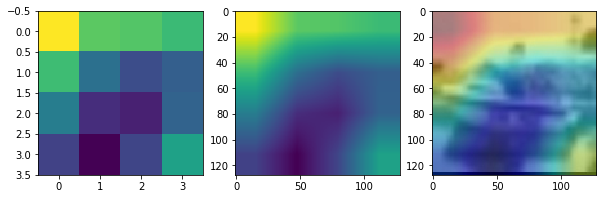

In [18]:
import cv2

fig, axs = plt.subplots(1, 3, figsize=(10,10))

axs[0].imshow(scaled_cam)

resized_cam = cv2.resize(scaled_cam, (128, 128))

axs[1].imshow(resized_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * resized_cam), cv2.COLORMAP_JET)

img = cv2.imread(img_path)
img = cv2.resize(img, (128,128))
heatimg = heatmap*0.4 + img*0.5
cv2.imwrite('./cam.jpg', heatimg)

cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)

axs[2].imshow(cam_img)

Before: float32
After: uint8
number of contours: 2


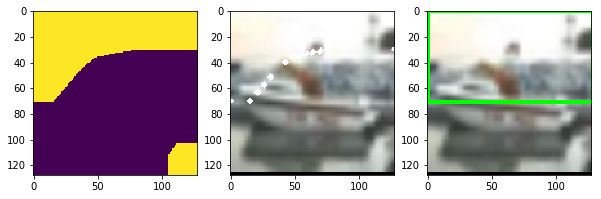

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10,10))

threshold = 0.5

_, thresholded_heatmap = cv2.threshold(resized_cam, threshold * resized_cam.max(), 1, cv2.THRESH_BINARY)

axs[0].imshow(thresholded_heatmap)

print('Before:',thresholded_heatmap.dtype)
thresholded_heatmap = cv2.convertScaleAbs(thresholded_heatmap)
print('After:',thresholded_heatmap.dtype)

contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours:',len(contours))

contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))
    
# contour 면적이 큰 순서대로 정렬
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)

# # contour 면적이 큰 contours 선택
biggest_contour= sorted_contours[0][1]

# -1 : represent entire contours
# (255, 255, 255): color
# 3 : thinkness 
contour_image = cv2.drawContours(img.copy(), biggest_contour, -1, (255, 255, 255), 3)
axs[1].imshow(contour_image)

x,y,w,h = cv2.boundingRect(biggest_contour)
box_image = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255,0), 2)

axs[2].imshow(box_image)